# CIFAR 10 Classifier

CIFAR10 is a classic data set for image recognition, which contains 10 types of pictures. The dataset has 60,000 color images of size 32 x 32, of which 50,000 are used for training and 10,000 are used for testing.

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

Check the GPU whether available

In [4]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
device

device(type='cuda')

## Data preprocessing
Implement data augmentation 

In [5]:
# Define a transformation pipeline for the training set
transform_tr = transforms.Compose([
    transforms.RandomHorizontalFlip(), # Randomly flip images horizontally
    transforms.RandomGrayscale(), # Randomly convert to grayscale
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalize pixel values
    ]) 

# Define a transformation pipeline for the test set
transform_te = transforms.Compose([
    transforms.ToTensor(), # Convert images to tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalize pixel values
    ]) 

# Load the CIFAR-10 training dataset with the specified transformations
train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_tr)

# Load the CIFAR-10 test dataset with the specified transformations
test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_te)

# Define the class labels for the CIFAR-10 dataset
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:23<00:00, 7122897.17it/s] 


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [17]:
# Show the information of the datasets
print('Train data information:\n',train_set)
print('Test data information:\n',test_set)

Train data information:
 Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               RandomGrayscale(p=0.1)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Test data information:
 Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


## Creat DataLoader
To split the training set of CIFAR-10 into training, validation, and test sets and create DataLoader instances for each set while shuffling the data within each set.

In [18]:
from torch.utils.data import DataLoader, Subset

# Set a random seed
np.random.seed(0)

# Create a random permutation of indices for the entire training set
order = np.random.permutation(len(train_set))

# Split the shuffled indices into validation (first 10,000) and training (remaining) sets
validation = Subset(train_set, order[0:10000])
train = Subset(train_set, order[10000:])

# Define the batch size for DataLoader
batch_size = 20

# Create DataLoader instances for training, validation, and test sets
loaders = {
    'train': DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=0),
    'validation': DataLoader(validation, batch_size=batch_size, shuffle=True, num_workers=0),
    'test': DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=0),
}

### Show the batch images and classes

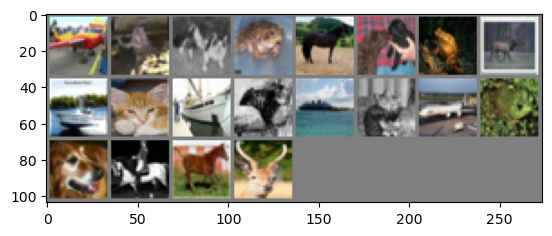

Labels: plane frog cat frog horse dog frog deer ship cat ship cat ship cat plane frog dog horse horse deer


In [19]:
import matplotlib.pyplot as plt

# Function to display an image
def imshow(img):
    # Unnormalize the image (reverse normalization)
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Transpose to (H x W x C)
    plt.show()

# Get a batch of random training images
dataiter = iter(loaders['train'])
images, labels = next(dataiter)

# Display the images
imshow(torchvision.utils.make_grid(images))

# Print the labels
label_names = [classes[labels[j]] for j in range(batch_size)]
print('Labels: {}'.format(' '.join(label_names)))

## Create a CNN model
This model includes convolutional layers for feature extraction and fully connected layers for classification. The use of batch normalization and dropout can help improve training and prevent overfitting.

In [21]:
import torch.nn as nn
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=3,              
                out_channels=32,            
                kernel_size=3,              
                stride=1,                   
                padding=1                  
            ),
            nn.BatchNorm2d(32), # Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 1, 1),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),    
        )        
        
        self.conv2 = nn.Sequential(         
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(), 
            nn.Conv2d(128, 128, 3, 1, 1),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        
        self.conv3 = nn.Sequential(         
            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, 1, 1),     
            nn.ReLU(),
            nn.MaxPool2d(2),                
        )
        
        self.fc1 = nn.Linear(4096, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)
        self.relu = nn.ReLU() 
        self.dropout = nn.Dropout(p=.3) #Randomly zero out each element 
  
    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.dropout(self.conv3(x))
        x = torch.flatten(x, 1)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.fc3(x)
        return x



## ML training pipeline

In [34]:
import torch.optim as optim  

def setup_model():
    model = CNN().to(device)
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    return model, criterion, optimizer

In [36]:
# Define constants
learning_rate = 0.001
epochs = 30

# Set up the model, loss function, and optimizer
model, criterion, optimizer = setup_model()

# Define empty lists to collect loss and accuracy values
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []


# Training loop
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in loaders['train']:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Append training loss to the list
    train_losses.append(running_loss / len(loaders['train']))

    # Calculate training accuracy and append to the list
    train_accuracy = 100 * correct / total
    train_accuracies.append(train_accuracy)

    model.eval()
    valid_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in loaders['validation']:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Append validation loss to the list
    valid_losses.append(valid_loss / len(loaders['validation']))

    # Calculate validation accuracy and append to the list
    valid_accuracy = 100 * correct / total
    valid_accuracies.append(valid_accuracy)

    # Print the progress after the 5th epoch
    if (epoch+1)%5 == 0:  # 0-based index, so epoch 5
        print(f"epoch: {epoch+1}, Training Loss: {train_losses[-1]}, Validation Loss: {valid_losses[-1]}, Training Accuracy: {train_accuracies[-1]}%, Validation Accuracy: {valid_accuracies[-1]}%")


epoch: 4, Training Loss: 0.9118028509914875, Validation Loss: 0.8257384964823723, Training Accuracy: 68.48%, Validation Accuracy: 72.13%


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

# Plotting code
plt.figure(figsize=(12, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

In [27]:
model.load_state_dict(torch.load('cifar_net.pth'))
model.eval()

correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

total_correct = 0
total_samples = 0

for images, labels in loaders['test']:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predictions = torch.max(outputs, 1)

    for label, prediction in zip(labels, predictions):
        if label == prediction:
            correct_pred[classes[label]] += 1
        total_pred[classes[label]] += 1

    total_correct += torch.sum(predictions == labels).item()
    total_samples += labels.size(0)

# Calculate overall accuracy
overall_accuracy = (total_correct / total_samples) * 100

# Print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = (correct_count / total_pred[classname]) * 100
    print(f'Accuracy for class {classname:5s}: {accuracy:.1f}%')

# Print overall accuracy
print(f'Overall accuracy: {overall_accuracy:.2f}%')


Accuracy for class plane: 82.9%
Accuracy for class car  : 85.2%
Accuracy for class bird : 77.7%
Accuracy for class cat  : 75.7%
Accuracy for class deer : 89.0%
Accuracy for class dog  : 75.1%
Accuracy for class frog : 81.0%
Accuracy for class horse: 88.3%
Accuracy for class ship : 93.8%
Accuracy for class truck: 97.1%
Overall accuracy: 84.58%


In [18]:
# print accuracy of all classes
total_num = 0
total_correct_num = 0

for classname, correct_count in correct_pred.items():
    total_num += total_pred[classname]
    total_correct_num += correct_count

total_accuracy = 100 * float(total_correct_num) / total_num

print(f'Accuracy for all classes: {total_accuracy:.1f} %')

Accuracy for all classes: 85.7 %
